In [2]:
import pandas as pd
location = "/mnt/c/Users/sauba/Desktop/20.RERConverge_trimmed/unTrimmed/3.For_tree"
csv_file = pd.read_csv(f"{location}/ERC_correlation.csv")

csv_file.index = csv_file.columns
string_to_remove = "_nostop.fas.aligned.fas.best"
csv_file.columns = csv_file.columns.str.replace(string_to_remove, "", regex=False)
csv_file.index = csv_file.index.str.replace(string_to_remove, "", regex=False)

string_to_remove = ".fas.ClipKIT"
csv_file.columns = csv_file.columns.str.replace(string_to_remove, "", regex=False)
csv_file.index = csv_file.index.str.replace(string_to_remove, "", regex=False)


matrix_long = csv_file.reset_index().melt(
    id_vars="index",         # Keeps row names as a column
    var_name="Gene1",       # New name for columns
    value_name="Gene2"       # New name for matrix values
)

# Rename 'index' to 'Row' for clarity
diapause = matrix_long.rename(columns={"index": "Row"})

location = "/mnt/c/Users/sauba/Desktop/20.RERConverge_trimmed/3.ERC_new_diapause_nondia/3.For Clusturing"

# diapause = pd.read_csv(f"{location}/ERC_correlation_diapause_long.csv")
# location = "/mnt/c/Users/Saurav Baral/Desktop/20.RERConverge_trimmed/unTrimmed/3.For_tree"
gene_anno_dic = {}
with open(f"{location}/correlation_2_with_annotation.csv", 'r') as cor_file:
    for lines in cor_file.readlines()[1:]:
        gene_name = lines.split(",")[0].split("_")[0][1:]
        anno_name = lines.split(",")[-1].replace('"', '')
        gene_anno_dic[gene_name]= anno_name.strip()


diapause_rn = diapause.rename(columns={"Gene2": "Correlation"})
diapause_rn = diapause_rn.rename(columns={"Gene1": "Gene2"})
diapause_rn = diapause_rn.rename(columns={"Row": "Gene1"})

def check_annotation(name):
    return gene_anno_dic.get(name, name)

diapause_rn["Annotation_gene1"] = diapause_rn["Gene1"].apply(check_annotation)
diapause_rn["Annotation_gene2"] = diapause_rn["Gene2"].apply(check_annotation)

diapause_rn["Correlation"].fillna(1, inplace=True)

# print(diapause_rn)

genes = diapause_rn["Gene1"].unique()
# df_filtered = diapause_rn[diapause_rn["Correlation"] >= 0.1]
# diapause_rn["Correlation"] += 1
df_filtered = diapause_rn
gene_dictionary = {}
to_remove = ["tim","9062at7088","per","TIMELESS","CLOCK"]
for row in df_filtered.itertuples():
    if (row.Annotation_gene1 not in to_remove) and (row.Annotation_gene2 not in to_remove):
        if row.Annotation_gene1 not in gene_dictionary:
            gene_dictionary[row.Annotation_gene1] = {}
        if row.Annotation_gene1 != row.Annotation_gene2:
            gene_dictionary[row.Annotation_gene1][row.Annotation_gene2] = row.Correlation

gene_dict = gene_dictionary
print("done")



done


In [3]:
import networkx as nx
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform

genes = list(gene_dict.keys())

# Initialize a similarity matrix
n = len(genes)
similarity_matrix = np.zeros((n, n))



for i, gene1 in enumerate(genes):
    for j, gene2 in enumerate(genes):
        if gene2 in gene_dict[gene1]:
            similarity_matrix[i, j] = round(gene_dict[gene1][gene2],2)
            similarity_matrix[j, i] = round(gene_dict[gene1][gene2],2)  # Ensure symmetry
        else:
            similarity_matrix[i, j] = 0  # No direct similarity (or self-similarity)
            similarity_matrix[j, i] = 0


min_similarity = np.min(similarity_matrix)
print(min_similarity)

# Convert similarity matrix to a distance matrix
distance_matrix = 1 - similarity_matrix

np.fill_diagonal(distance_matrix, 0)

# Flatten the distance matrix to a condensed form (required by scipy)
condensed_distance_matrix = squareform(distance_matrix)


print(similarity_matrix)
print(distance_matrix)

-0.58
[[ 0.    0.19  0.19 ...  0.03  0.27  0.21]
 [ 0.19  0.    0.07 ...  0.17  0.14  0.11]
 [ 0.19  0.07  0.   ...  0.    0.34  0.32]
 ...
 [ 0.03  0.17  0.   ...  0.    0.09 -0.04]
 [ 0.27  0.14  0.34 ...  0.09  0.    0.35]
 [ 0.21  0.11  0.32 ... -0.04  0.35  0.  ]]
[[0.   0.81 0.81 ... 0.97 0.73 0.79]
 [0.81 0.   0.93 ... 0.83 0.86 0.89]
 [0.81 0.93 0.   ... 1.   0.66 0.68]
 ...
 [0.97 0.83 1.   ... 0.   0.91 1.04]
 [0.73 0.86 0.66 ... 0.91 0.   0.65]
 [0.79 0.89 0.68 ... 1.04 0.65 0.  ]]


In [4]:
def average_similarity(cluster, similarity_matrix, genes):
    """
    Compute the average similarity within a cluster.
    """
    if len(cluster) < 2:
        return 0.0  # No similarity for single-gene clusters
    
    # Get indices of genes in the cluster
    indices = [genes.index(gene) for gene in cluster]
    
    # Extract the submatrix for the cluster
    submatrix = similarity_matrix[np.ix_(indices, indices)]
    
    # Compute the average similarity (excluding diagonal)
    return np.sum(submatrix) / (len(cluster) * (len(cluster) - 1))


In [5]:
import statistics

import matplotlib.pyplot as plt


def get_clusters(i):
    n_clusters = i # Adjust this based on your needs
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters,
        affinity="precomputed",  # Use precomputed distances
        linkage="average"  # You can change this to "single", "complete", or "ward"
    )
    
    # Fit the model
    clustering.fit(distance_matrix)
    
    # Get the cluster labels
    labels = clustering.labels_
    
    # Organize genes into clusters
    clusters = {}
    for gene, label in zip(genes, labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(gene)
    return(clusters)
    # Print the clusters
    

In [31]:
number_of_cluster = []
mean_cluster_size = []
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
for i in range(2000,3000,50):
    i = 2450
    clusters = get_clusters(i)
    similarity_list = []
    cluster_size_list = [1,]
    
    for cluster_id, genes_in_cluster in clusters.items():
    
        
        if len(genes_in_cluster) > 2 and round(average_similarity(genes_in_cluster, similarity_matrix, genes),2) >0.40:
            print(cluster_id, genes_in_cluster)
            similarity_list.append(average_similarity(genes_in_cluster, similarity_matrix, genes))
            cluster_size_list.append(len(genes_in_cluster))
        # if "period" in genes_in_cluster and len(genes_in_cluster) <= 5 :
        #     print(f"Cluster {cluster_id}: {genes_in_cluster}, {average_similarity(genes_in_cluster, similarity_matrix, genes)}")
        # if "cycle" in genes_in_cluster:
        #         print(f"Cluster {cluster_id}: {genes_in_cluster}, {average_similarity(genes_in_cluster, similarity_matrix, genes)}")


            
            
    number_of_cluster.append(len(cluster_size_list))
    mean_cluster_size.append(statistics.mean(cluster_size_list))
    break
# print(number_of_cluster,mean_cluster_size)

    # print(i,statistics.mean(similarity_list),statistics.median(similarity_list))
    # # plt.hist(similarity_list, bins=30, color='skyblue', edgecolor='black')
    # # plt.show()
    # print(i,statistics.mean(cluster_size_list),statistics.median(cluster_size_list), len(cluster_size_list))
    
    # plt.hist(cluster_size_list, bins=300, color='skyblue', edgecolor='black')
    # plt.xlim(0, 10)
    # plt.show()
    # break

257 ['npr-9', 'SCP2', '9737at7088']
1 ['NPEPL1', '11937at7088', 'DNAJC3', 'AP3B2', 'MED16', '4545at7088', 'TPP2', 'DPF3', 'BRD7', 'SMC2', '5925at7088', 'CPSF2', 'C16orf70', 'SNX27']
52 ['NR2C2', 'ACVR1', 'AGPS', 'EDRF1', 'CDC25A', 'NUBP1']
3 ['AASS', '3496at7088', 'SLC17A6']
948 ['LANCL1', 'USP46', 'NGLY1', 'CDK20', 'RpS27', '11493at7088', 'HPS4', 'IMP3', 'GANC', 'DGCR14', 'TRAFD1', '5723at7088', 'UNC13C', 'pck', '15652at7088', 'CNPY3', 'SASH1', '3197at7088', 'SMARCA4', '10066at7088', 'VPS51', 'KIAA1598', 'ERGIC3', 'PAPSS2', '1343at7088', 'EGR1', 'NOSIP', 'TOLLIP', 'PTPN14', 'TMEM50A', 'STK17B', '7385at7088', 'PQLC1', 'MARS2', 'ANKS1A', 'CALU']
8 ['13753at7088', 'mrpl-11', 'EMG1', 'DDX10', 'UBE2G2']
793 ['RAPH1', '3985at7088', 'RALGPS2', 'Nep2', 'KCNT2']
368 ['PRRC2C', '758at7088', '13093at7088', 'KMT2A', 'PLEKHA5']
12 ['10291at7088', 'PSME3', 'VPS26B', 'ING4']
653 ['GINS2', 'GAS8', 'DYNLRB2']
1103 ['NDUFB2', 'SAV1', 'ANAPC11', 'AP1B1', '4454at7088']
20 ['TENM2', '1711at7088', '1684at7

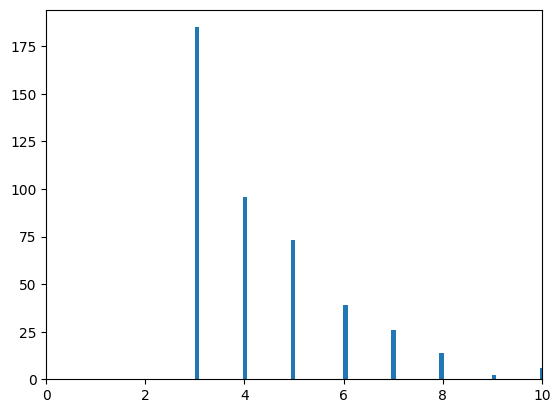

In [53]:
plt.xlim(0, 10)
plt.hist(cluster_size_list,bins=3000)
plt.show()

2450


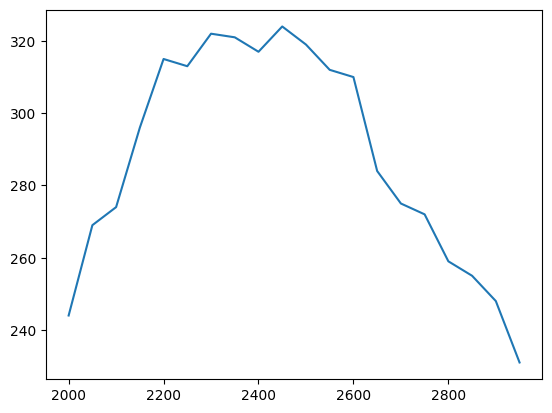

In [30]:
x = range(2000,3000,50)
plt.plot(x,number_of_cluster)
max_index = number_of_cluster.index(max(number_of_cluster))
print(x[max_index])
plt.show()

In [10]:
list_of_size = []
for cluster_id, genes_in_cluster in clusters.items():
    if len(genes_in_cluster) > 3:
        print(cluster_id, len(genes_in_cluster))
        list_of_size.append(len(genes_in_cluster))
print(statistics.mean(list_of_size))

130 7
75 136
427 6
598 37
600 5
34 6
200 7
431 4
91 4
1103 5
671 4
945 154
921 11
1263 8
332 10
149 5
359 4
234 31
331 33
126 15
864 27
104 12
572 5
503 4
252 8
21 13
817 6
57 29
90 6
33 4
67 4
155 7
11 5
464 6
311 4
144 23
638 5
24 11
926 4
42 20
10 4
323 5
354 13
560 4
9 5
221 9
0 11
634 4
312 4
77 6
38 7
938 6
216 8
770 4
559 4
556 4
214 7
767 4
665 20
723 4
217 8
172 5
878 4
59 23
644 6
392 6
261 4
29 4
785 5
399 5
79 10
219 5
204 21
236 10
64 25
69 4
78 7
337 22
411 4
461 10
946 5
883 4
154 8
362 4
430 10
394 4
167 11
275 5
190 13
1006 7
366 6
92 9
96 4
280 5
237 4
128 4
487 4
1019 6
718 7
906 4
1645 5
1134 8
402 5
949 6
627 4
936 4
153 4
625 4
1505 4
742 8
5 4
919 4
348 6
15 5
786 4
1498 4
146 4
462 5
1149 4
473 10
23 5
324 6
347 5
37 12
28 4
468 4
228 10
27 6
398 5
546 4
108 17
138 5
137 5
176 15
165 4
995 4
688 5
1858 7
1384 4
94 4
85 5
345 4
232 16
123 4
286 7
573 4
307 9
160 5
747 4
41 4
668 4
439 11
1896 4
745 4
335 4
50 6
358 4
363 4
410 6
139 4
20 6
178 5
320 4
383 4
429 4